# Проект 11. Временные ряды.

## Прогноз заказов такси

Исходные данные - исторические данные о заказах такси в аэропортах. 

Задача - спрогнозировать количество заказов такси на следующий час, постройте модель для такого предсказания.

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy import stats as st
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


from sklearn.metrics import  mean_squared_error


In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.sort_index(inplace=True)
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [5]:
df = df.set_index('datetime')
df.index.is_monotonic

True

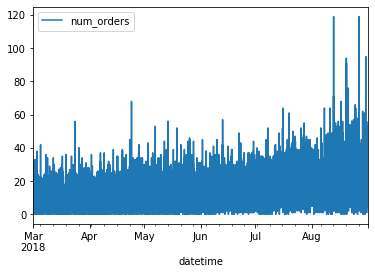

In [6]:
df.plot()

# 2. Анализ

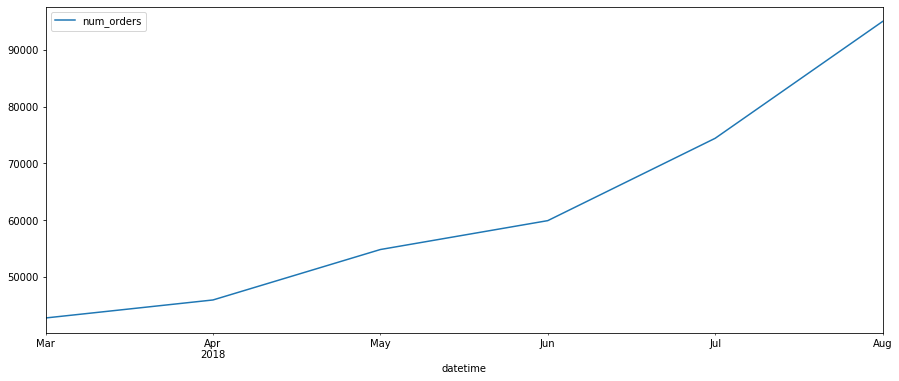

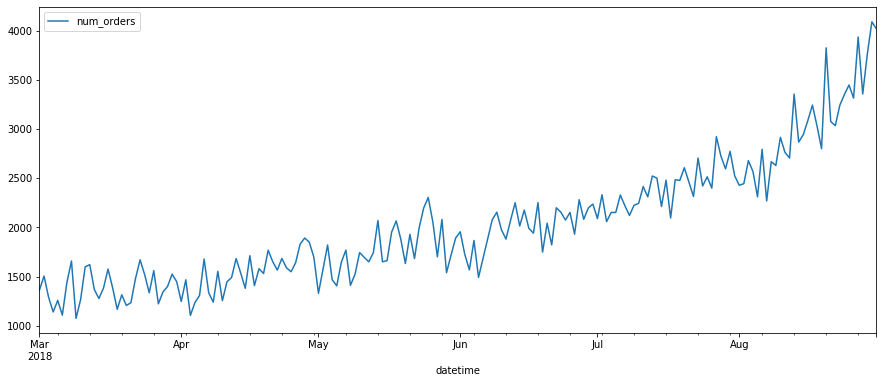

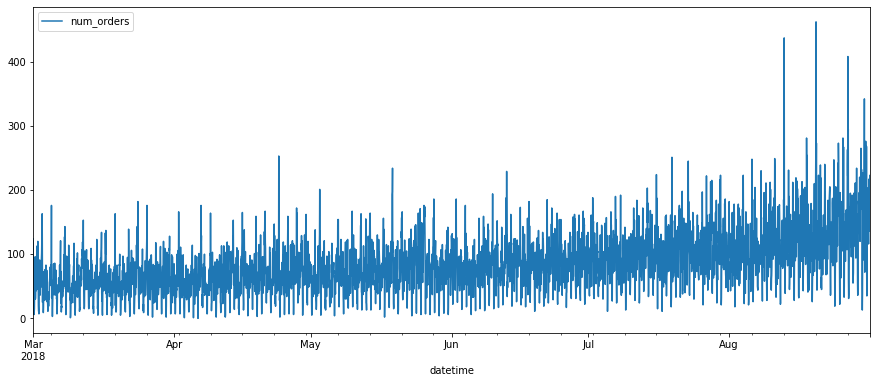

In [7]:
df.resample('1M').sum().plot(figsize=(15, 6))
df.resample('1D').sum().plot(figsize=(15, 6))
df = df.resample('1H').sum()
df.plot(figsize=(15, 6))


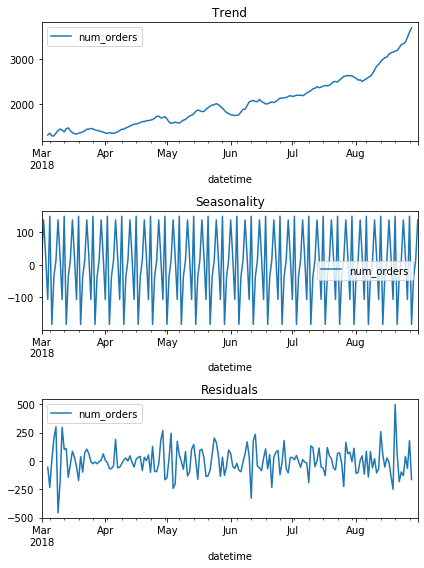

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1D').sum()

decomposed = seasonal_decompose(data)

#decomposed.seasonal.plot()


plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

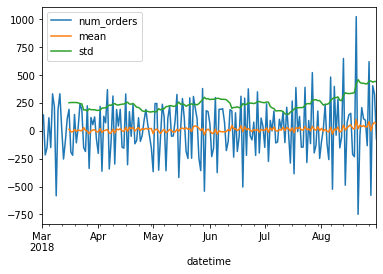

In [9]:
data = data - data.shift()  # < напишите код здесь >
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot()

Ряд нестационарный, т.к. со временем меняется стреднее значение

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
make_features(df, 5, 4)
df.head(30)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,86.50
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,66.25
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,46.50
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,31.75
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,19.00


In [12]:
train, valid_plus_test = train_test_split(df, shuffle=False, test_size=0.4, random_state=123)
valid, test = train_test_split(valid_plus_test, shuffle=False, test_size=0.25, random_state=123)
train = train.dropna()
valid = valid.dropna()
test = test.dropna()
print('Обучающая выборка:')
print(train.shape)
print(train.index.min(), train.index.max())
print('-----')
print('Валидационная выборка:')
print(valid.shape)
print(valid.index.min(), valid.index.max())
print('-----')
print('Тестовая выборка:')
print(test.shape)
print(test.index.min(), test.index.max())

Обучающая выборка:
(2644, 9)
2018-03-01 05:00:00 2018-06-19 08:00:00
-----
Валидационная выборка:
(1325, 9)
2018-06-19 09:00:00 2018-08-13 13:00:00
-----
Тестовая выборка:
(442, 9)
2018-08-13 14:00:00 2018-08-31 23:00:00


In [13]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# 3. Обучение

In [14]:
import seaborn as sns
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_valid.columns).sort_values(ascending=False).head(10)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

In [15]:
%%time
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)

predicted_linear = model_linear.predict(features_valid)

mse_linear = mean_squared_error(target_valid, predicted_linear)

print("MSE =", mse_linear)
print("RMSE =", mse_linear ** 0.5)

MSE = 1529.562911133861
RMSE = 39.10962683450024
CPU times: user 8.05 ms, sys: 8.62 ms, total: 16.7 ms
Wall time: 8.32 ms


best model depth = 4
MSE = 1552.608110153612
RMSE = 39.40314848021173
CPU times: user 145 ms, sys: 0 ns, total: 145 ms
Wall time: 233 ms


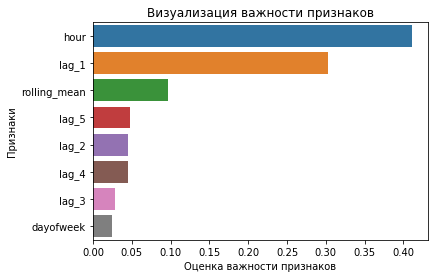

In [16]:
%%time
best_model = None 
best_result = 10000
best_depth = 0
for depth in range(1, 10, 1):
    model_tree = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train) 
    predicted_tree = model_tree.predict(features_valid) 
    result_tree = mean_squared_error(target_valid, predicted_tree) ** 0.5 
    if result_tree < best_result:
        best_model = model_tree
        best_result = result_tree
        best_depth = depth
        mse_tree = mean_squared_error(target_valid, predicted_tree)

print('best model depth =', best_depth)
print("MSE =", mse_tree)
print("RMSE =", mse_tree ** 0.5)

chart_feature_imp(model_tree)

Best forest depth = 10
Best number of estimators = 20
MSE = 1179.1921802211975
RMSE = 34.33936779006273
CPU times: user 5.83 s, sys: 26.2 ms, total: 5.86 s
Wall time: 5.87 s


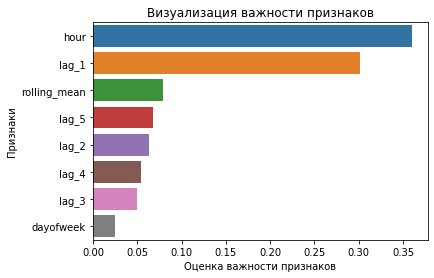

In [17]:
%%time
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 50, 10):
    for depth in range (1, 11):
        model_forest = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train)
        predicted_forest = model_forest.predict(features_valid)
        result_forest = mean_squared_error(target_valid, predicted_forest) ** 0.5
        if result_forest < best_result:
            best_model = model_forest
            best_result = result_forest
            best_est = est
            best_depth = depth
            mse_forest = mean_squared_error(target_valid, predicted_forest)

            
print('Best forest depth =', best_depth)
print('Best number of estimators =', best_est)
print("MSE =", mse_forest)
print("RMSE =", mse_forest ** 0.5)

chart_feature_imp(model_forest)

In [18]:
%%time
model_cat = CatBoostRegressor(verbose=100)
model_cat.fit(features_train, target_train)

0:	learn: 32.9418829	total: 49.1ms	remaining: 49.1s
100:	learn: 21.7456345	total: 1.54s	remaining: 13.7s
200:	learn: 20.0232748	total: 3.11s	remaining: 12.3s
300:	learn: 18.8625204	total: 4.67s	remaining: 10.8s
400:	learn: 17.9649522	total: 6.25s	remaining: 9.33s
500:	learn: 17.2828620	total: 8.19s	remaining: 8.16s
600:	learn: 16.6706557	total: 9.86s	remaining: 6.54s
700:	learn: 16.0813349	total: 11.8s	remaining: 5.03s
800:	learn: 15.5038793	total: 13.5s	remaining: 3.35s
900:	learn: 14.9924482	total: 15.2s	remaining: 1.67s
999:	learn: 14.5359918	total: 16.8s	remaining: 0us
CPU times: user 15.2 s, sys: 1.96 s, total: 17.2 s
Wall time: 18.6 s


MSE = 1058.7036268099878
RMSE = 32.53772620835678
CPU times: user 56.7 ms, sys: 11.7 ms, total: 68.4 ms
Wall time: 67.3 ms


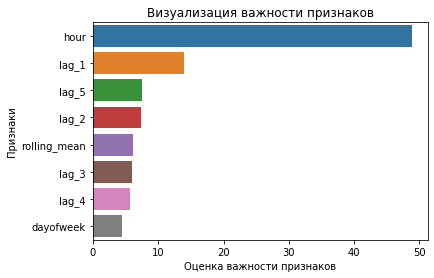

In [19]:
%%time
predicted_cat = model_cat.predict(features_valid)

mse_cat = mean_squared_error(target_valid, predicted_cat)

print("MSE =", mse_cat)
print("RMSE =", mse_cat ** 0.5)

chart_feature_imp(model_cat)

In [20]:
%%time
model_lgb = LGBMRegressor()
model_lgb.fit(features_train, target_train)

CPU times: user 1.13 s, sys: 29.1 ms, total: 1.16 s
Wall time: 1.18 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

MSE = 1099.4576718368853
RMSE = 33.15807099088976
CPU times: user 99.4 ms, sys: 8.41 ms, total: 108 ms
Wall time: 124 ms


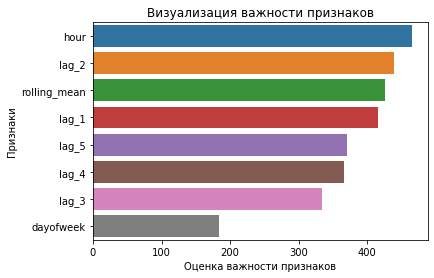

In [21]:
%%time
predicted_lgb = model_lgb.predict(features_valid)

mse_lgb = mean_squared_error(target_valid, predicted_lgb)

print("MSE =", mse_lgb)
print("RMSE =", mse_lgb ** 0.5)

chart_feature_imp(model_lgb)

# 4. Тестирование

In [22]:
predicted_linear = model_linear.predict(features_test)

mse_linear = mean_squared_error(target_test, predicted_linear)

print("MSE =", mse_linear)
print("RMSE =", mse_linear ** 0.5)

MSE = 3622.134031905324
RMSE = 60.18416761828084


,target,prediction
datetime,,
2018-08-13 14:00:00,102,91.910648
2018-08-13 15:00:00,175,88.908240
2018-08-13 16:00:00,144,126.867286
2018-08-13 17:00:00,152,115.369333
2018-08-13 18:00:00,104,119.746013


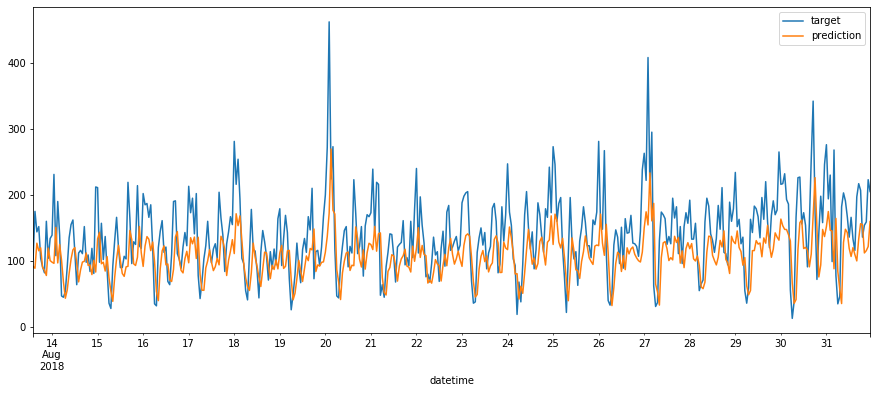

In [23]:
linear = pd.DataFrame()
linear['target'] = target_test
linear['prediction'] = predicted_linear
linear.plot(figsize=(15, 6))
linear.head()

In [24]:
predicted_tree = model_tree.predict(features_test)

mse_tree = mean_squared_error(target_test, predicted_tree) ** 0.5

print("MSE =", mse_tree)
print("RMSE =", mse_tree ** 0.5)

MSE = 77.8331560935591
RMSE = 8.822310133607813


,target,prediction
datetime,,
2018-08-13 14:00:00,102,48.000000
2018-08-13 15:00:00,175,80.931034
2018-08-13 16:00:00,144,80.931034
2018-08-13 17:00:00,152,112.333333
2018-08-13 18:00:00,104,32.545455


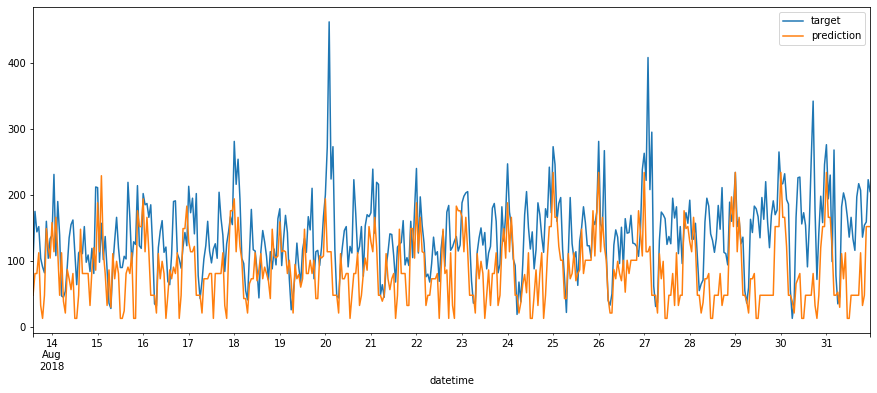

In [25]:
tree = pd.DataFrame()
tree['target'] = target_test
tree['prediction'] = predicted_tree
tree.plot(figsize=(15, 6))
tree.head()

In [26]:
predicted_forest = model_forest.predict(features_test)

mse_forest = mean_squared_error(target_test, predicted_forest) ** 0.5

print("MSE =", mse_forest)
print("RMSE =", mse_forest ** 0.5)

MSE = 66.81626425033312
RMSE = 8.174121619497297


,target,prediction
datetime,,
2018-08-13 14:00:00,102,69.013453
2018-08-13 15:00:00,175,78.807107
2018-08-13 16:00:00,144,80.529491
2018-08-13 17:00:00,152,90.781671
2018-08-13 18:00:00,104,72.801241


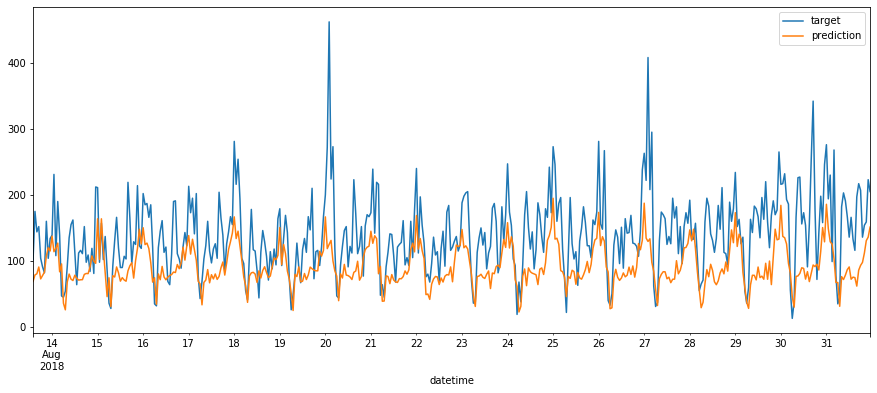

In [27]:
forest = pd.DataFrame()
forest['target'] = target_test
forest['prediction'] = predicted_forest
forest.plot(figsize=(15, 6))
forest.head()

In [28]:
predicted_cat = model_cat.predict(features_test)

mse_cat = mean_squared_error(target_test, predicted_cat)

print("MSE =", mse_cat)
print("RMSE =", mse_cat ** 0.5)

MSE = 3817.8950979865263
RMSE = 61.78911795766732


,target,prediction
datetime,,
2018-08-13 14:00:00,102,88.067753
2018-08-13 15:00:00,175,97.058344
2018-08-13 16:00:00,144,105.360770
2018-08-13 17:00:00,152,73.530756
2018-08-13 18:00:00,104,85.983144


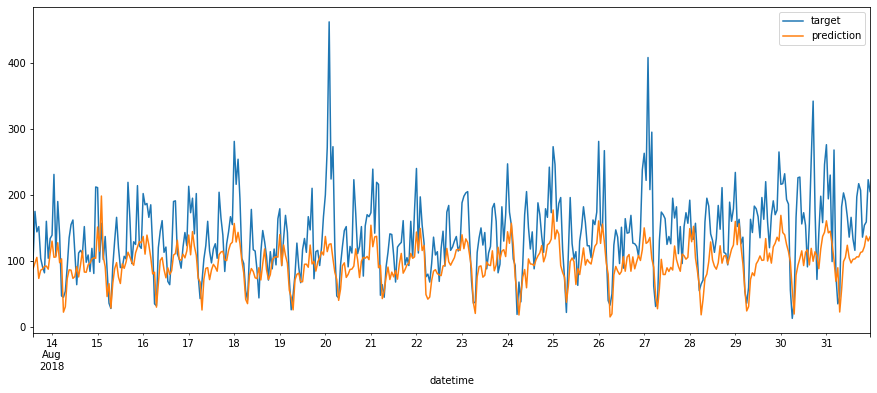

In [29]:
cat = pd.DataFrame()
cat['target'] = target_test
cat['prediction'] = predicted_cat
cat.plot(figsize=(15, 6))
cat.head()

In [30]:
predicted_lgb = model_lgb.predict(features_test)

mse_lgb = mean_squared_error(target_test, predicted_lgb)

print("MSE =", mse_lgb)
print("RMSE =", mse_lgb ** 0.5)

MSE = 4145.261733901232
RMSE = 64.38370705311424


,target,prediction
datetime,,
2018-08-13 14:00:00,102,60.923359
2018-08-13 15:00:00,175,88.716988
2018-08-13 16:00:00,144,70.773084
2018-08-13 17:00:00,152,105.531936
2018-08-13 18:00:00,104,90.072838


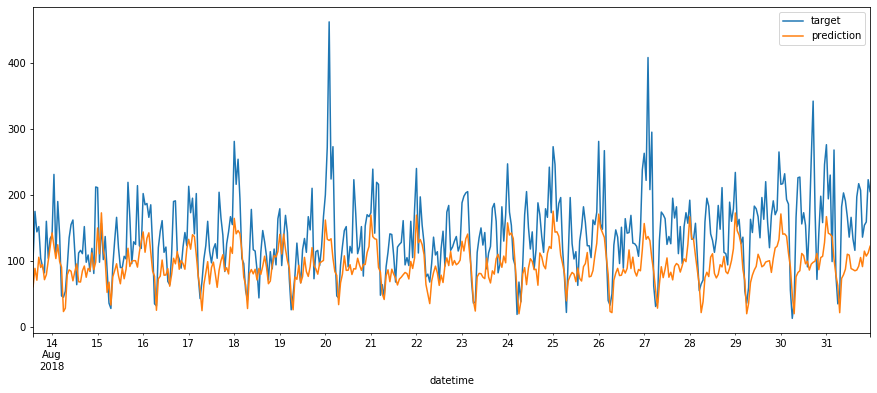

In [31]:
lgb = pd.DataFrame()
lgb['target'] = target_test
lgb['prediction'] = predicted_lgb
lgb.plot(figsize=(15, 6))
lgb.head()

# Выводы

В результате выполнения проекта построена модель машинного обученния, которая прогнозирует количество заказов на будущие промежутки времени с минимальным значением метрики RMSE на тестовой выборке.

Также в процессе выполнения работы была выполнена предподготовка данных, анализ временных рядов, создание тренировочной, валидационной и тестовой выборки, обучение разных видов моделей машинного обучения, вывод значения целевой метрики и важности признаков для каждой модели, а также проверка результата на тестовой выборке. В принципе все рассмотренные модели удовлетворяют условию технического задания и имеют RMSE < 48. Однако как наиболее быстро работающую модель, я бы рекомендовал использовать DecisionTreeRegressor, как модель с самым быстрым временем работы и отличным значением целевой метрики на тестовой выборке (RMSE=3.3)

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48